# Assignment

In [1]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import os

# import from files
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *

from neural_net import *
from helper_functions import *

In [2]:
plt.rc('font', size=13) #controls default text size
plt.rc('axes', titlesize=13) #fontsize of the title
plt.rc('axes', labelsize=13) #fontsize of the x and y labels
plt.rc('xtick', labelsize=13) #fontsize of the x tick labels
plt.rc('ytick', labelsize=13) #fontsize of the y tick labels
plt.rc('legend', fontsize=13) #fontsize of the legend

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     - S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     - X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     - allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     - R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     - Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [3]:
## INITIALISE THE ENVIRONMENT

size_board = 4
env=Chess_Env(size_board)

# Random moves

In [4]:
## PRINT 5 STEPS OF AN EPISODE CONSIDERING A RANDOM AGENT

S,X,allowed_a=env.Initialise_game()                       # INTIALISE GAME

print(S)                                                  # PRINT CHESS BOARD (SEE THE DESCRIPTION ABOVE)

print('check? ',env.check)                                # PRINT VARIABLE THAT TELLS IF ENEMY KING IS IN CHECK (1) OR NOT (0)
print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))    # PRINT THE NUMBER OF LOCATIONS THAT THE ENEMY KING CAN MOVE TO


for i in range(5):
    
    a,_=np.where(allowed_a==1)                  # FIND WHAT THE ALLOWED ACTIONS ARE
    a_agent=np.random.permutation(a)[0]         # MAKE A RANDOM ACTION

    S,X,allowed_a,R,Done=env.OneStep(a_agent)   # UPDATE THE ENVIRONMENT
    
    
    ## PRINT CHESS BOARD AND VARIABLES
    print('')
    print(S)
    print(R,'', Done)
    print('check? ',env.check)
    print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))
    
    
    # TERMINATE THE EPISODE IF Done=True (DRAW OR CHECKMATE)
    if Done:
        break
        


[[0 0 0 0]
 [0 1 0 0]
 [0 0 0 2]
 [3 0 0 0]]
check?  0
dofk2  1

[[0 0 0 0]
 [0 1 2 0]
 [0 0 0 0]
 [0 3 0 0]]
0  0
check?  0
dofk2  0

[[0 0 1 0]
 [0 0 2 0]
 [3 0 0 0]
 [0 0 0 0]]
0  0
check?  0
dofk2  1

[[0 0 0 1]
 [0 0 2 0]
 [0 0 0 0]
 [0 3 0 0]]
0  0
check?  0
dofk2  1

[[0 0 2 1]
 [0 0 0 0]
 [0 0 0 0]
 [3 0 0 0]]
0  0
check?  0
dofk2  2

[[0 0 2 0]
 [0 0 1 0]
 [0 0 0 0]
 [0 3 0 0]]
0  0
check?  0
dofk2  2


# Initialize game and set fixed parameters

In [5]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 


S,X,allowed_a=env.Initialise_game()

N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in=np.shape(X)[0]    ## INPUT SIZE

# Choosing Hyperparameters
Here I set the hyperparameters that are shared for all 3 reinforcement learning algorithms (Q-Learning, SARSA and DQN) to allow for a fair comparison. I used the provided default parameters, as they tend to perform very well on this task. The network architecture is also identical for all 3 algorithms.

In [6]:
# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

# defaults
# epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
# beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
# gamma = 0.85        # THE DISCOUNT FACTOR
# eta = 0.0035        # THE LEARNING RATE

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE
N_h=200                ## NUMBER OF HIDDEN NODES

# DQN speific parameters
C = 10  # number of steps after which the target network is updated
capacity = 100_000  # capacity of the replay memory
batch_size = 32  # size of the batch


# number of games to be played
N_episodes = 100_000 
# N_episodes = 50_000
# N_episodes = 5_000

# chose method ("sarsa", "qlearning" or "dqn")
method = "qlearning"

# choose activation functions: "relu", "sigmoid", "tanh", None (identity)
act1 = "relu"
act2 = None

# not a hyperparameter ;) (it's just here so that all parameters for initialization and training are in one place for better overview)
seed = 21

# name extension for saving the results
name_extension = f"seed_{seed}"

# Training Agents for All Algorithms

## Q-Learning Agent
this agent trained in about 8 minutes for 100'000 episodes.

In [7]:
# instantiate the neural net for the qlearning agent
method = "qlearning"

qlearning = NeuralNetwork(N_in, N_h, N_a, activation_function_1=act1, activation_function_2=act2, method=method, seed=seed)

# train the agent
qlearning.train(env, N_episodes, eta, epsilon_0, beta, gamma)

  0%|          | 0/100000 [00:00<?, ?episodes/s]

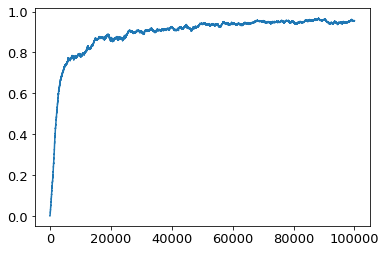

In [8]:
ema = exponential_moving_average(qlearning.R_history)
plt.plot(ema)

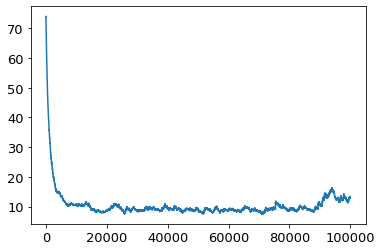

In [9]:
ema = exponential_moving_average(qlearning.N_moves_history)
plt.plot(ema)

[]

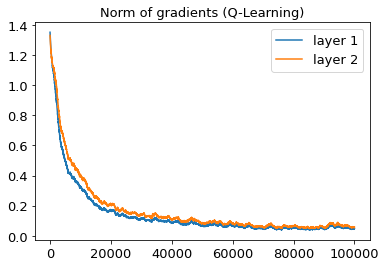

In [10]:
ema_1 = exponential_moving_average(qlearning.dL_dW1_norm_history)
ema_2 = exponential_moving_average(qlearning.dL_dW2_norm_history)
plt.plot(ema_1, label="layer 1")
plt.plot(ema_2, label="layer 2")
plt.title("Norm of gradients (Q-Learning)")
plt.legend()
plt.plot()

In [11]:
# save model
qlearning.save(name_extension)

saving to: models/qlearning_relu_None_seed_21


## SARSA Agent
this agent trained in about 3 minutes.

In [12]:
# instantiate the neural net for the sarsa agent
method = "sarsa"

sarsa = NeuralNetwork(N_in, N_h, N_a, activation_function_1=act1, activation_function_2=act2, method=method, seed=seed)

# train the agent
sarsa.train(env, N_episodes, eta, epsilon_0, beta, gamma)

  0%|          | 0/100000 [00:00<?, ?episodes/s]

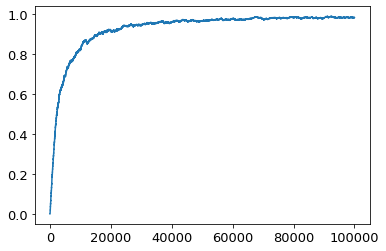

In [13]:
ema = exponential_moving_average(sarsa.R_history)
plt.plot(ema)

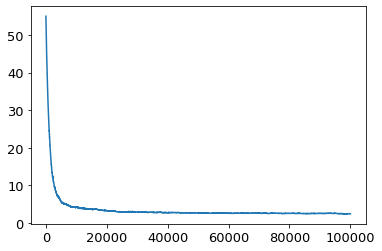

In [14]:
ema = exponential_moving_average(sarsa.N_moves_history)
plt.plot(ema)

[]

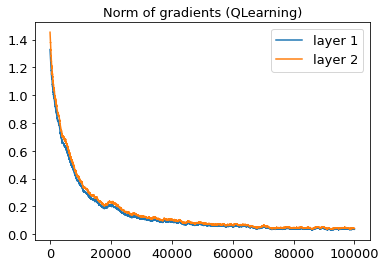

In [15]:
ema_1 = exponential_moving_average(sarsa.dL_dW1_norm_history)
ema_2 = exponential_moving_average(sarsa.dL_dW2_norm_history)
plt.plot(ema_1, label="layer 1")
plt.plot(ema_2, label="layer 2")
plt.title("Norm of gradients (QLearning)")
plt.legend()
plt.plot()

In [16]:
# save model
sarsa.save(name_extension)

saving to: models/sarsa_relu_None_seed_21


## DQN Agent (with Experience Replay and Target Network)

In [17]:
# instantiate the neural net for the sarsa agent
method = "dqn"

dqn = NeuralNetwork(N_in, N_h, N_a, activation_function_1=act1, activation_function_2=act2, method=method, seed=seed, C=C)

# train the agent
dqn.train(env, N_episodes, eta, epsilon_0, beta, gamma, batch_size=batch_size)

  0%|          | 0/100000 [00:00<?, ?episodes/s]

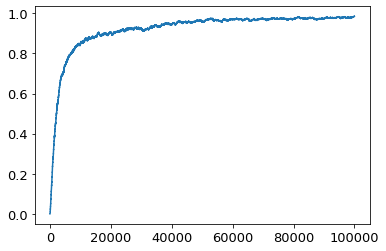

In [18]:
ema = exponential_moving_average(dqn.R_history)
plt.plot(ema)

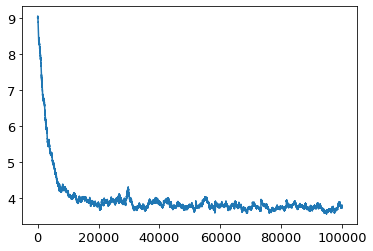

In [19]:
ema = exponential_moving_average(dqn.N_moves_history)
plt.plot(ema)

[]

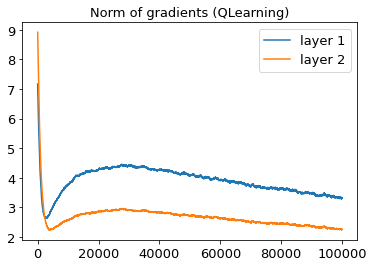

In [20]:
ema_1 = exponential_moving_average(dqn.dL_dW1_norm_history)
ema_2 = exponential_moving_average(dqn.dL_dW2_norm_history)
plt.plot(ema_1, label="layer 1")
plt.plot(ema_2, label="layer 2")
plt.title("Norm of gradients (QLearning)")
plt.legend()
plt.plot()

In [21]:
# save model
dqn.save(name_extension)

saving to: models/dqn_relu_None_seed_21


# Training without Seed
We train the agents again, but this time without setting a seed. Because this makes it impossible to reproduce exactly we train each algorithm multiple times (multiple runs) and average the results per episode. Then we compute the EMA on the averaged results in case the results are still too noisy. For computational reasons we limit the number of runs to 30, which should be enough of variation to see some trends.

In [22]:
# parameters

N_episodes = 40_000

n_cpus = 2
print(f"number of cpus: {n_cpus}")

n_runs = 30
print(f"number of runs: {n_runs}")

number of cpus: 2
number of runs: 30


In [23]:
def training_runs(run_number):
    # initialise the network
    nn = NeuralNetwork(N_in, N_h, N_a, activation_function_1=act1, activation_function_2=act2, method=method, seed=None)
    
    # # train the network
    nn.train(env, N_episodes, eta, epsilon_0, beta, gamma, run_number=run_number)

    # save the model
    name_extension = f"run_{run_number}"
    nn.save(name_extension)

    # return reward history and number of moves history
    return nn.R_history, nn.N_moves_history, nn.training_time_in_seconds, nn.dL_dW1_norm_history, nn.dL_dW2_norm_history


def run_in_serial(method, n_runs):
    histories = []
    for i in np.arange(n_runs):
        histories.append(training_runs(i))

    save_avg_statistics(histories, method)


def run_in_parallel(method, n_cpus, n_runs):
    # start pool of processes
    p = Pool(processes=n_cpus)

    try:
        # run the training runs
        print("starting training runs...")
        histories = p.map(training_runs, np.arange(n_runs))
        p.close()

        # save summary statistics
        save_avg_statistics(histories, method)
    except KeyboardInterrupt:
        p.close()

## Q-Learning

In [24]:
method = "qlearning"
run_in_serial(method, n_runs)
# run_in_parallel(method, n_cpus, n_runs)

  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/qlearning_relu_None_run_0


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/qlearning_relu_None_run_1


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/qlearning_relu_None_run_2


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/qlearning_relu_None_run_3


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/qlearning_relu_None_run_4


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/qlearning_relu_None_run_5


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/qlearning_relu_None_run_6


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/qlearning_relu_None_run_7


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/qlearning_relu_None_run_8


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/qlearning_relu_None_run_9


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/qlearning_relu_None_run_10


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/qlearning_relu_None_run_11


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/qlearning_relu_None_run_12


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/qlearning_relu_None_run_13


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/qlearning_relu_None_run_14


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/qlearning_relu_None_run_15


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/qlearning_relu_None_run_16


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/qlearning_relu_None_run_17


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/qlearning_relu_None_run_18


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/qlearning_relu_None_run_19


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/qlearning_relu_None_run_20


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/qlearning_relu_None_run_21


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/qlearning_relu_None_run_22


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/qlearning_relu_None_run_23


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/qlearning_relu_None_run_24


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/qlearning_relu_None_run_25


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/qlearning_relu_None_run_26


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/qlearning_relu_None_run_27


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/qlearning_relu_None_run_28


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/qlearning_relu_None_run_29


## SARSA

In [25]:
method = "sarsa"
run_in_serial(method, n_runs)
# run_in_parallel(method, n_cpus, n_runs)

  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/sarsa_relu_None_run_0


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/sarsa_relu_None_run_1


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/sarsa_relu_None_run_2


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/sarsa_relu_None_run_3


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/sarsa_relu_None_run_4


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/sarsa_relu_None_run_5


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/sarsa_relu_None_run_6


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/sarsa_relu_None_run_7


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/sarsa_relu_None_run_8


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/sarsa_relu_None_run_9


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/sarsa_relu_None_run_10


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/sarsa_relu_None_run_11


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/sarsa_relu_None_run_12


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/sarsa_relu_None_run_13


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/sarsa_relu_None_run_14


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/sarsa_relu_None_run_15


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/sarsa_relu_None_run_16


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/sarsa_relu_None_run_17


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/sarsa_relu_None_run_18


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/sarsa_relu_None_run_19


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/sarsa_relu_None_run_20


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/sarsa_relu_None_run_21


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/sarsa_relu_None_run_22


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/sarsa_relu_None_run_23


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/sarsa_relu_None_run_24


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/sarsa_relu_None_run_25


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/sarsa_relu_None_run_26


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/sarsa_relu_None_run_27


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/sarsa_relu_None_run_28


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/sarsa_relu_None_run_29


## DQN

In [26]:
method = "dqn"
run_in_serial(method, n_runs)
# run_in_parallel(method, n_cpus, n_runs)

  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/dqn_relu_None_run_0


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/dqn_relu_None_run_1


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/dqn_relu_None_run_2


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/dqn_relu_None_run_3


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/dqn_relu_None_run_4


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/dqn_relu_None_run_5


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/dqn_relu_None_run_6


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/dqn_relu_None_run_7


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/dqn_relu_None_run_8


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/dqn_relu_None_run_9


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/dqn_relu_None_run_10


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/dqn_relu_None_run_11


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/dqn_relu_None_run_12


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/dqn_relu_None_run_13


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/dqn_relu_None_run_14


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/dqn_relu_None_run_15


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/dqn_relu_None_run_16


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/dqn_relu_None_run_17


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/dqn_relu_None_run_18


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/dqn_relu_None_run_19


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/dqn_relu_None_run_20


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/dqn_relu_None_run_21


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/dqn_relu_None_run_22


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/dqn_relu_None_run_23


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/dqn_relu_None_run_24


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/dqn_relu_None_run_25


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/dqn_relu_None_run_26


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/dqn_relu_None_run_27


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/dqn_relu_None_run_28


  0%|          | 0/40000 [00:00<?, ?episodes/s]

saving to: models/dqn_relu_None_run_29
